For the following code, everything is explained in the comments throughout, which is why I have not included a README file.

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# The dataset is accessible here:
# https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

# The website hosting the dataset required a login
# to access the files, so I instead uploaded the files
# to my own Google Drive and accessed them here.
# When running this code yourself, set 'path_train' to be the path to the 
# training .csv file, and set 'path_test' to be the path to the
# testing .csv file.
path_train = '/content/drive/MyDrive/Classes/3. Junior/Spring 2022/Data Mining/Final Project/Project Resources/Corona_NLP_train.csv'
path_test = '/content/drive/MyDrive/Classes/3. Junior/Spring 2022/Data Mining/Final Project/Project Resources/Corona_NLP_test.csv'

# Read the CSV files from the paths specified above. I ignore encoding errors
# here because some symbols weren't rendering properly.
train_df = pd.read_csv(path_train, encoding="latin1")
test_df = pd.read_csv(path_test, encoding="latin1")

# Create a validation dataset and drop those values from the training set
valid_df = train_df.sample(frac=0.1, random_state=1)
train_df=train_df.drop(valid_df.index)

# Re-index the dataframes after removing values
valid_df.index=range(len(valid_df))
train_df.index=range(len(train_df))

# Check the sizes of the training/validation/testing sets
print("Training set: " + str(len(train_df)))
print("Validation set: " + str(len(valid_df)))
print("Testing set: " + str(len(test_df)))

# This method creates separate dataframes with just indices and tweets/labels
def get_tweets(data):
  tweets = data['OriginalTweet']
  labels = data['Sentiment']
  return tweets, labels

train_tweets, train_labels = get_tweets(train_df)

# Initializes a tokenizer and calibrates it to training data
# Tokenization is the process of splitting sentences into tokens,
# as well as getting rid of unimportant characters, e.g. punctuation.
# This specific tokenizer will assign each word a number by how 
# commonly they appear in the dataset of Tweets.
tokenizer = Tokenizer(num_words = 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_tweets)

# Make all sequences the same shape
# maxlen gets the length of the longest tweet so every other tweet can be
# padded until they are all the same length
maxlen = max([len(x.split()) for x in train_tweets])
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post',
                         maxlen=maxlen)
  return padded

# padded_train_seq now contains a 64-length array of each Tweet in the training
# dataset, starting with the tokenized values of the tweet and padded with 0s
padded_train_seq = get_sequences(tokenizer, train_tweets)

# Creates a set of training labels, and a dictionary for converting classes
# to indices and vice versa. This is useful when converting values returned by
# the model into something easier to understand later.
classes = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

# This function converts labels in the training data to their respective indices
names_to_ids = lambda train_labels: np.array([class_to_index.get(x) for x in train_labels])
labels = names_to_ids(train_labels)

# With all of the preprocessing done, it's time to work on the model itself

Training set: 37041
Validation set: 4116
Testing set: 3798


Epoch 1/20
1158/1158 [==============================] - 106s 82ms/step - loss: 1.1798 - accuracy: 0.4987 - val_loss: 0.8665 - val_accuracy: 0.6757
Epoch 2/20
1158/1158 [==============================] - 93s 81ms/step - loss: 0.6870 - accuracy: 0.7549 - val_loss: 0.7455 - val_accuracy: 0.7303
Epoch 3/20
1158/1158 [==============================] - 93s 80ms/step - loss: 0.5525 - accuracy: 0.8143 - val_loss: 0.7024 - val_accuracy: 0.7500
Epoch 4/20
1158/1158 [==============================] - 93s 80ms/step - loss: 0.4847 - accuracy: 0.8414 - val_loss: 0.7228 - val_accuracy: 0.7512
Epoch 5/20
1158/1158 [==============================] - 93s 81ms/step - loss: 0.4302 - accuracy: 0.8615 - val_loss: 0.7176 - val_accuracy: 0.7592
Epoch 6/20
1158/1158 [==============================] - 92s 80ms/step - loss: 0.3782 - accuracy: 0.8796 - val_loss: 0.7571 - val_accuracy: 0.7539
Epoch 7/20
1158/1158 [==============================] - 93s 80ms/step - loss: 0.3363 - accuracy: 0.8933 - val_loss: 0.7736 

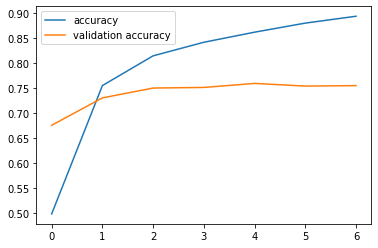

In [ ]:
# Create a Sequential model that uses Embedding, Bidirectional, and Dense layers
# Each of these layers will be explained in more deail in the paper
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                      20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

# Compiles the model; these choices will be explained in the paper
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

# Performs the same preprocessing steps as earlier on the validation dataset
# in order to allow validation steps to take place
val_tweets, val_labels = get_tweets(valid_df)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

# Train the model and evaluate it with training and validation accuracy
hist = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=2)]
)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='upper left')
plt.show()

Epoch 1/20
1158/1158 [==============================] - 104s 83ms/step - loss: 1.3550 - accuracy: 0.4144 - val_loss: 0.9459 - val_accuracy: 0.6365
Epoch 2/20
1158/1158 [==============================] - 94s 81ms/step - loss: 0.8168 - accuracy: 0.7068 - val_loss: 0.7730 - val_accuracy: 0.7106
Epoch 3/20
1158/1158 [==============================] - 95s 82ms/step - loss: 0.6379 - accuracy: 0.7909 - val_loss: 0.7648 - val_accuracy: 0.7381
Epoch 4/20
1158/1158 [==============================] - 94s 81ms/step - loss: 0.5503 - accuracy: 0.8282 - val_loss: 0.6978 - val_accuracy: 0.7604
Epoch 5/20
1158/1158 [==============================] - 94s 81ms/step - loss: 0.4934 - accuracy: 0.8509 - val_loss: 0.7456 - val_accuracy: 0.7524
Epoch 6/20
1158/1158 [==============================] - 94s 82ms/step - loss: 0.4440 - accuracy: 0.8683 - val_loss: 0.7461 - val_accuracy: 0.7590


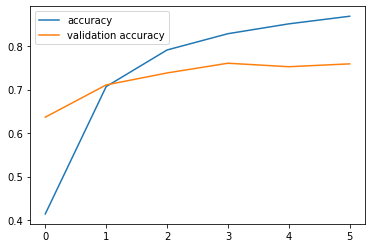

In [ ]:
# The previous model is prone to overfitting, so I'm going to see if applying
# dropout regularization helps the performance of the validation step
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                      20, return_sequences=True)),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

hist = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=2)]
)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='upper left')
plt.show()

Epoch 1/20
1158/1158 [==============================] - 103s 83ms/step - loss: 1.3257 - accuracy: 0.4245 - val_loss: 0.9998 - val_accuracy: 0.6016
Epoch 2/20
1158/1158 [==============================] - 94s 81ms/step - loss: 0.7566 - accuracy: 0.7237 - val_loss: 0.7338 - val_accuracy: 0.7417
Epoch 3/20
1158/1158 [==============================] - 94s 81ms/step - loss: 0.5653 - accuracy: 0.8084 - val_loss: 0.7047 - val_accuracy: 0.7563
Epoch 4/20
1158/1158 [==============================] - 93s 80ms/step - loss: 0.4860 - accuracy: 0.8441 - val_loss: 0.7059 - val_accuracy: 0.7602
Epoch 5/20
1158/1158 [==============================] - 94s 81ms/step - loss: 0.4351 - accuracy: 0.8636 - val_loss: 0.7221 - val_accuracy: 0.7634
Epoch 6/20
1158/1158 [==============================] - 94s 81ms/step - loss: 0.3875 - accuracy: 0.8807 - val_loss: 0.7102 - val_accuracy: 0.7583
Epoch 7/20
1158/1158 [==============================] - 93s 81ms/step - loss: 0.3400 - accuracy: 0.8954 - val_loss: 0.7483 

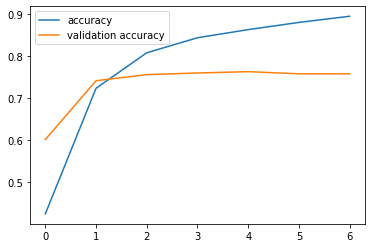

In [ ]:
# I noticed that for previous tests the enumerations made no sense: before, they
# were as follows:
# 0 - Extremely Negative
# 1 - Extremely Positive
# 2 - Negative
# 3 - Neutral
# 4 - Positive
# For this attempt, I made changes as follows:
# 0 - Extremely Negative
# 1 - Negative
# 2 - Neutral
# 3 - Positive
# 4 - Extremely Positive
# This way similar judgements would have a more sensible loss value - before,
# guessing an "extremely negative" text as "extremely positive" would only
# result in a loss of 1, while "positive" and "extremely positive" would result
# in a loss of 3.

# Create a Sequential model that uses Embedding, Bidirectional, and Dense layers
# Each of these layers will be explained in more deail in the paper
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                      20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

# Compiles the model; these choices will be explained in the paper
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

# Performs the same preprocessing steps as earlier on the validation dataset
# in order to allow validation steps to take place
val_tweets, val_labels = get_tweets(valid_df)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

# Train the model and evaluate it with training and validation accuracy
hist = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=2)]
)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='upper left')
plt.show()

Epoch 1/20
1158/1158 [==============================] - 106s 85ms/step - loss: 1.4790 - accuracy: 0.3307 - val_loss: 1.2962 - val_accuracy: 0.4487
Epoch 2/20
1158/1158 [==============================] - 96s 83ms/step - loss: 1.1427 - accuracy: 0.5303 - val_loss: 0.9095 - val_accuracy: 0.6531
Epoch 3/20
1158/1158 [==============================] - 95s 82ms/step - loss: 0.9139 - accuracy: 0.6500 - val_loss: 0.7819 - val_accuracy: 0.7080
Epoch 4/20
1158/1158 [==============================] - 95s 82ms/step - loss: 0.8062 - accuracy: 0.7015 - val_loss: 0.7337 - val_accuracy: 0.7381
Epoch 5/20
1158/1158 [==============================] - 96s 83ms/step - loss: 0.7396 - accuracy: 0.7335 - val_loss: 0.7167 - val_accuracy: 0.7512
Epoch 6/20
1158/1158 [==============================] - 95s 82ms/step - loss: 0.7089 - accuracy: 0.7466 - val_loss: 0.6892 - val_accuracy: 0.7563
Epoch 7/20
1158/1158 [==============================] - 95s 82ms/step - loss: 0.6745 - accuracy: 0.7624 - val_loss: 0.6964 

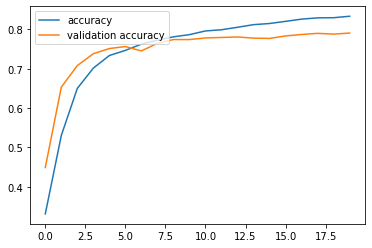

In [ ]:
# Here, I'm combining the past two solutions in an attempt to find better results.
# I disabled the early stopping because I noticed sometimes the val_accuracy
# would improve over the course of multiple epochs.
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                      20, return_sequences=True)),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

hist = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
#    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                                                  patience=2)]
)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='upper left')
plt.show()

Epoch 1/20
1158/1158 [==============================] - 107s 86ms/step - loss: 1.3809 - accuracy: 0.3908 - val_loss: 0.9908 - val_accuracy: 0.6118
Epoch 2/20
1158/1158 [==============================] - 98s 85ms/step - loss: 0.9640 - accuracy: 0.6262 - val_loss: 0.8077 - val_accuracy: 0.7187
Epoch 3/20
1158/1158 [==============================] - 97s 84ms/step - loss: 0.8176 - accuracy: 0.6978 - val_loss: 0.7165 - val_accuracy: 0.7502
Epoch 4/20
1158/1158 [==============================] - 98s 84ms/step - loss: 0.7528 - accuracy: 0.7288 - val_loss: 0.6572 - val_accuracy: 0.7741
Epoch 5/20
1158/1158 [==============================] - 97s 84ms/step - loss: 0.7072 - accuracy: 0.7490 - val_loss: 0.6449 - val_accuracy: 0.7801
Epoch 6/20
1158/1158 [==============================] - 97s 84ms/step - loss: 0.6742 - accuracy: 0.7632 - val_loss: 0.6289 - val_accuracy: 0.7891
Epoch 7/20
1158/1158 [==============================] - 97s 84ms/step - loss: 0.6475 - accuracy: 0.7709 - val_loss: 0.6229 

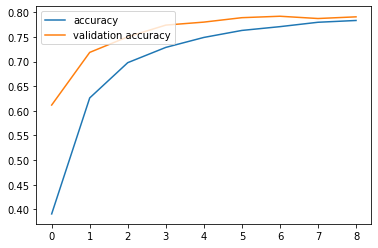

In [ ]:
# Disabling the early stopping led to some promising results, albeit at a slow
# pace. For this attempt, I increased the learning rate of the optimizer.
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
                                      20, return_sequences=True)),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01
    ),
    metrics='accuracy'
)

hist = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=2,
                                                  restore_best_weights=True)]
)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# With the model resulting in a validation accuracy of over 80%, it's time to
# test the performance of the model on the testing set.

test_tweets, test_labels = get_tweets(test_df)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)
model.evaluate(test_seq, test_labels)

119/119 [==============================] - 2s 18ms/step - loss: 0.6493 - accuracy: 0.7699


[0.6493099927902222, 0.7698788642883301]